In [1]:
import warnings
warnings.filterwarnings("ignore")

# Basic libs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Try import for dendrogram
try:
    from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

print("Ready. Packages loaded (scipy available = {})".format(SCIPY_AVAILABLE))


Ready. Packages loaded (scipy available = True)


1) LOAD DATA (defensive)

In [2]:

DATA_PATH = "clusteringmidterm.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Place dataset in working dir or change DATA_PATH.")

# Try load with header; if first row looks numeric -> load without header
df_try = pd.read_csv(DATA_PATH, nrows=5)
# Heuristic: if all column names are numeric strings, assume no header
cols_numeric_like = all(str(c).replace('.', '', 1).lstrip('-').isdigit() for c in df_try.columns)

if cols_numeric_like:
    df = pd.read_csv(DATA_PATH, header=None)
    # assign generic column names, but if there's CUST_ID in first column we will detect later
    df.columns = [f"col_{i}" for i in range(df.shape[1])]
    print("Loaded CSV without header — assigned generic column names.")
else:
    df = pd.read_csv(DATA_PATH)
    print("Loaded CSV with header.")

print("Shape:", df.shape)
display(df.head())


Loaded CSV with header.
Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


2) QUICK EDA

In [ ]:
print("=== Info ===")
display(df.info())

print("\n=== Describe (numeric) ===")
display(df.describe().T)

print("\n=== Missing values (top 20) ===")
display(df.isnull().sum().sort_values(ascending=False).head(20))


3) PREPROCESSING

In [ ]:
df_proc = df.copy()

id_candidates = ["CUST_ID", "Cust_id", "CustID", "ID", "Id", "cust_id"]
found_id = None
for c in df_proc.columns:
    if c in id_candidates:
        found_id = c
        break
if found_id is None:
    first_col = df_proc.columns[0]
    if df_proc[first_col].nunique() == len(df_proc) and pd.api.types.is_integer_dtype(df_proc[first_col]) or df_proc[first_col].dtype == object:
        if df_proc[first_col].dtype == object or df_proc[first_col].nunique() > len(df_proc)*0.8:
            found_id = first_col

if found_id is not None:
    print(f"Dropping ID column detected: {found_id}")
    df_proc = df_proc.drop(columns=[found_id])

numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found for clustering. Please ensure dataset has numeric features.")
df_proc = df_proc[numeric_cols].copy()
print("Using numeric columns:", len(numeric_cols))

imputer = SimpleImputer(strategy="median")
df_proc[:] = imputer.fit_transform(df_proc)

zero_var_cols = df_proc.columns[df_proc.nunique() <= 1].tolist()
if zero_var_cols:
    print("Dropping zero-variance columns:", zero_var_cols)
    df_proc.drop(columns=zero_var_cols, inplace=True)

# Standardize
scaler = StandardScaler()
X = scaler.fit_transform(df_proc)

print("Preprocessing done. Shape after preprocess:", X.shape)


Dropping ID column detected: CUST_ID
Using numeric columns: 17
Preprocessing done. Shape after preprocess: (8950, 17)


4) DIMENSIONALITY REDUCTION for VISUALIZATION

In [4]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
print("PCA explained variance ratio (2 comps):", pca.explained_variance_ratio_)


PCA explained variance ratio (2 comps): [0.27297671 0.2031378 ]


5) FIND K (Elbow & Silhouette)

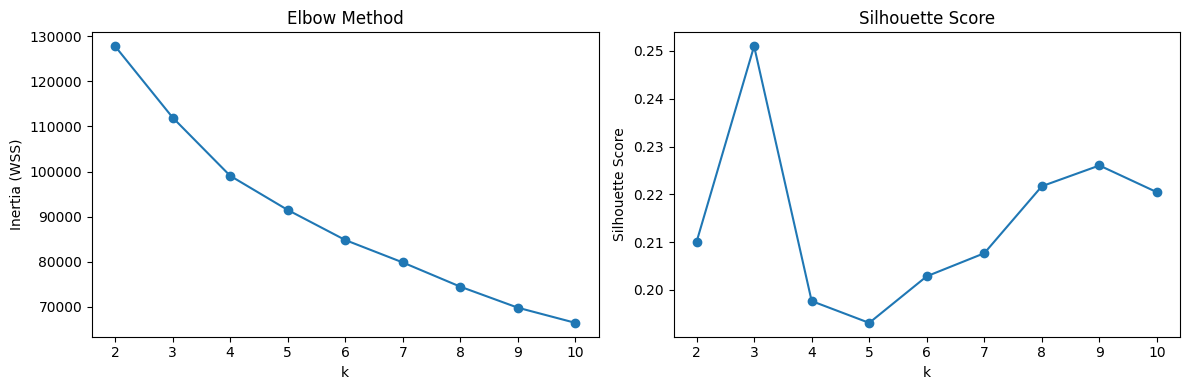

In [5]:
from sklearn.metrics import pairwise_distances_argmin_min

def plot_elbow_silhouette(X, k_range=range(2,11)):
    inertias = []
    silhouettes = []
    Ks = list(k_range)
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X)
        inertias.append(km.inertia_)
        sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 and len(X) > k else np.nan
        silhouettes.append(sil)
    # plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(Ks, inertias, marker='o')
    plt.xlabel("k")
    plt.ylabel("Inertia (WSS)")
    plt.title("Elbow Method")
    plt.subplot(1,2,2)
    plt.plot(Ks, silhouettes, marker='o')
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score")
    plt.tight_layout()
    plt.show()
    return Ks, inertias, silhouettes

Ks, inertias, silhouettes = plot_elbow_silhouette(X, range(2,11))


6) K-MEANS (choose k)

In [6]:
k_best = None
s_arr = np.array(silhouettes)
if np.all(np.isnan(s_arr)):
    k_best = 4  # default fallback
    print("No silhouette computed (maybe small sample). Using default k=4. You can change manually.")
else:
    # pick k with max silhouette
    k_best = int(Ks[np.nanargmax(s_arr)])
    print("Suggested best k by silhouette:", k_best)

k_best = max(2, k_best)  # ensure at least 2

kmeans = KMeans(n_clusters=k_best, random_state=42, n_init=20)
k_labels = kmeans.fit_predict(X)
print("KMeans done. n_clusters:", k_best)


Suggested best k by silhouette: 3
KMeans done. n_clusters: 3


Plot KMeans clusters on PCA

In [ ]:
# Plot KMeans clusters on PCA
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=k_labels, palette="tab10", legend="full", s=40)
plt.title(f"KMeans clusters (k={k_best}) projected to PCA-2D")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="cluster")
plt.show()

# Metrics
sil_k = silhouette_score(X, k_labels) if len(np.unique(k_labels))>1 else np.nan
db_k = davies_bouldin_score(X, k_labels) if len(np.unique(k_labels))>1 else np.nan
print(f"KMeans: silhouette={sil_k:.4f}, davies_bouldin={db_k:.4f}")


7) HIERARCHICAL (Dendrogram + clustering)

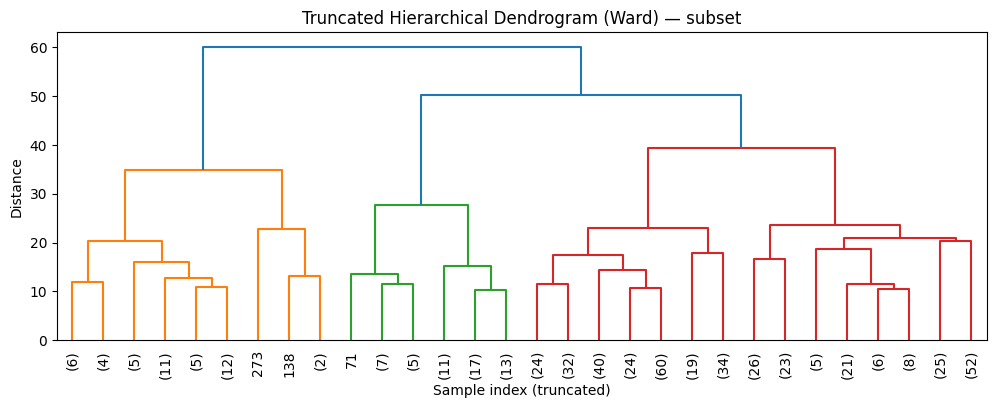

Hierarchical clustering labels computed on subset (size=500) with n_clusters = 3
Hierarchical (subset): silhouette=0.3365, davies_bouldin=1.3730


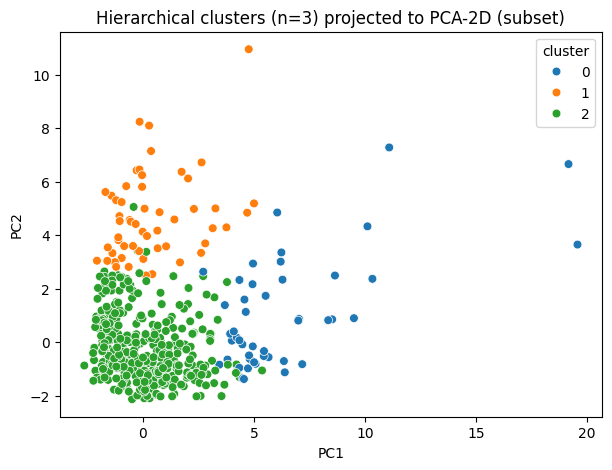

In [8]:
if not SCIPY_AVAILABLE:
    print("scipy not available -> skipping hierarchical dendrogram. Install scipy to enable this.")
else:
    max_subset = 500
    n_samples = X.shape[0]
    subset_size = min(max_subset, n_samples)
    subset_idx = np.arange(subset_size)
    X_sub = X[subset_idx]
    X_pca_sub = X_pca[subset_idx]

    # Compute linkage on subset
    Z = linkage(X_sub, method='ward')
    plt.figure(figsize=(12,4))
    dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
    plt.title("Truncated Hierarchical Dendrogram (Ward) — subset")
    plt.xlabel("Sample index (truncated)")
    plt.ylabel("Distance")
    plt.show()

    # choose number of clusters (use k_best from KMeans or manual)
    n_clusters_h = k_best if 'k_best' in globals() else 4
    h_labels_sub = fcluster(Z, n_clusters_h, criterion='maxclust') - 1
    print("Hierarchical clustering labels computed on subset (size={}) with n_clusters = {}".format(subset_size, n_clusters_h))

    try:
        if len(np.unique(h_labels_sub)) > 1:
            sil_h = silhouette_score(X_sub, h_labels_sub)
            db_h = davies_bouldin_score(X_sub, h_labels_sub)
        else:
            sil_h = np.nan
            db_h = np.nan
        print(f"Hierarchical (subset): silhouette={sil_h:.4f}, davies_bouldin={db_h:.4f}")
    except Exception as e:
        print("Could not compute hierarchical silhouette/db on subset:", e)


    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_pca_sub[:,0], y=X_pca_sub[:,1], hue=h_labels_sub, palette="tab10", s=40)
    plt.title(f"Hierarchical clusters (n={n_clusters_h}) projected to PCA-2D (subset)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.legend(title="cluster")
    plt.show()

    try:
        results_df  # if exists
    except NameError:
        results_df = pd.DataFrame(df_proc).copy()
    results_df['hier_cluster'] = np.nan
    results_df.loc[subset_idx, 'hier_cluster'] = h_labels_sub


8) DBSCAN

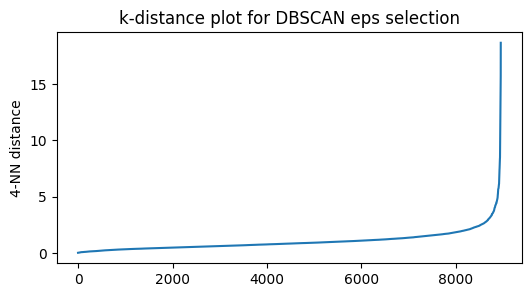

Using eps (90th percentile) = 1.8926158852376735
DBSCAN unique labels (including -1 noise): [-1  0]


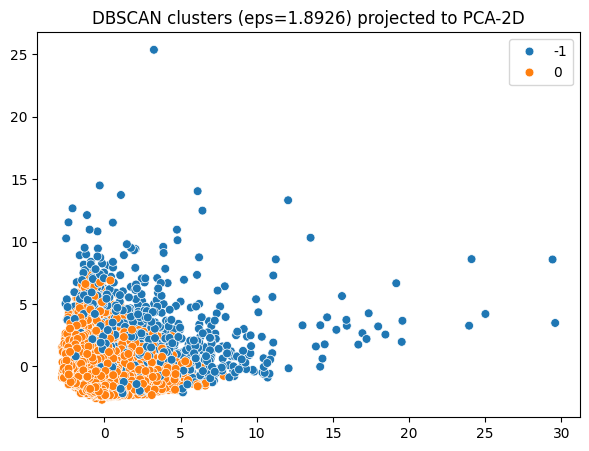

DBSCAN: silhouette=0.46061058641729097, davies_bouldin=2.1244023316315204


In [9]:
from sklearn.neighbors import NearestNeighbors

# compute k-distance for k = min_samples-1 (choose 4)
k = 4
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
# sort distances to find elbow
k_distances = np.sort(distances[:, k-1])
plt.figure(figsize=(6,3))
plt.plot(k_distances)
plt.ylabel(f"{k}-NN distance")
plt.title("k-distance plot for DBSCAN eps selection")
plt.show()

# heuristically pick eps as percentile of k_distances
eps = np.percentile(k_distances, 90)
print("Using eps (90th percentile) =", eps)

db = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
db_labels = db.fit_predict(X)
unique_db = np.unique(db_labels)
print("DBSCAN unique labels (including -1 noise):", unique_db)

# plot DBSCAN
plt.figure(figsize=(7,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_labels, palette="tab10", s=40)
plt.title(f"DBSCAN clusters (eps={eps:.4f}) projected to PCA-2D")
plt.show()

# DBSCAN metrics (if at least 2 clusters)
try:
    if len(np.unique(db_labels)) > 1:
        sil_db = silhouette_score(X, db_labels)
        db_db = davies_bouldin_score(X, db_labels)
    else:
        sil_db = np.nan
        db_db = np.nan
    print(f"DBSCAN: silhouette={sil_db}, davies_bouldin={db_db}")
except Exception as e:
    print("Could not compute DBSCAN metrics:", e)


9) SUMMARIZE & INTERPRET CLUSTERS

In [11]:
results_df = pd.DataFrame(df_proc).copy()
results_df["kmeans_cluster"] = k_labels

# --------- HIERARCHICAL CLUSTER (500 sample only) ----------
if SCIPY_AVAILABLE:
    full_h_labels = np.full(len(results_df), np.nan)
    full_h_labels[:len(h_labels)] = h_labels
    results_df["hier_cluster"] = full_h_labels
else:
    print("scipy not available → skipping hier_cluster column")

# --------- DBSCAN ----------
results_df["dbscan_cluster"] = db_labels

# SUMMARY STATISTICS (KMEANS)
print("KMeans cluster summary (count & mean):")
display(
    results_df.groupby("kmeans_cluster")
              .agg(['count', 'mean'])
              .T.iloc[:50, :]
)

# INTERPRETATION PER CLUSTER
cluster_cols = ["kmeans_cluster", "dbscan_cluster"]
if SCIPY_AVAILABLE:
    cluster_cols.append("hier_cluster")

# global mean (baseline)
global_mean = results_df.drop(columns=cluster_cols).mean()

interpretation = []

for c in sorted(results_df["kmeans_cluster"].unique()):
    cluster_mean = results_df[results_df["kmeans_cluster"] == c] \
                         .drop(columns=cluster_cols).mean()

    diff = (cluster_mean - global_mean).abs().sort_values(ascending=False).head(8)

    interpretation.append((c, diff.index.tolist(), diff.values.tolist()))

# tampilkan interpretasi
print("\nSuggested human-readable interpretations (top differing features per cluster):")
for c, feats, vals in interpretation:
    print(f"Cluster {c}: top different features -> {feats}")


KMeans cluster summary (count & mean):


kmeans_cluster                                    0            1            2
BALANCE                          count  6119.000000  1235.000000  1596.000000
                                 mean    799.750669  2220.003291  3989.142419
BALANCE_FREQUENCY                count  6119.000000  1235.000000  1596.000000
                                 mean      0.835077     0.981477     0.958403
PURCHASES                        count  6119.000000  1235.000000  1596.000000
                                 mean    505.532394  4268.520980   384.528277
ONEOFF_PURCHASES                 count  6119.000000  1235.000000  1596.000000
                                 mean    253.120131  2717.828543   248.718133
INSTALLMENTS_PURCHASES           count  6119.000000  1235.000000  1596.000000
                                 mean    252.733061  1551.178267   135.887632
CASH_ADVANCE                     count  6119.000000  1235.000000  1596.000000
                                 mean    330.817885   458.421147  3866.210340
PURCHASES_FREQUENCY              count  6119.000000  1235.000000  1596.000000
                                 mean      0.465072     0.949093     0.232290
ONEOFF_PURCHASES_FREQUENCY       count  6119.000000  1235.000000  1596.000000
                                 mean      0.132333     0.668166     0.110942
PURCHASES_INSTALLMENTS_FREQUENCY count  6119.000000  1235.000000  1596.000000
                                 mean      0.345145     0.744584     0.144242
CASH_ADVANCE_FREQUENCY           count  6119.000000  1235.000000  1596.000000
                                 mean      0.068260     0.063014     0.447393
CASH_ADVANCE_TRX                 count  6119.000000  1235.000000  1596.000000
                                 mean      1.209675     1.528745    12.397870
PURCHASES_TRX                    count  6119.000000  1235.000000  1596.000000
                                 mean      8.653865    56.472065     5.612155
CREDIT_LIMIT                     count  6119.000000  1235.000000  1596.000000
                                 mean   3271.510637  7733.967611  6675.441445
PAYMENTS                         count  6119.000000  1235.000000  1596.000000
                                 mean    909.677092  4151.276172  3019.108570
MINIMUM_PAYMENTS                 count  6119.000000  1235.000000  1596.000000
                                 mean    523.213219  1220.516917  1787.616215
PRC_FULL_PAYMENT                 count  6119.000000  1235.000000  1596.000000
                                 mean      0.155750     0.298632     0.033774
TENURE                           count  6119.000000  1235.000000  1596.000000
                                 mean     11.479654    11.923077    11.347744
hier_cluster                     count   289.000000   111.000000   100.000000
                                 mean      2.000000     1.135135     1.480000
dbscan_cluster                   count  6119.000000  1235.000000  1596.000000
                                 mean     -0.008335    -0.285830    -0.192982


Suggested human-readable interpretations (top differing features per cluster):
Cluster 0: top different features -> ['CREDIT_LIMIT', 'PAYMENTS', 'BALANCE', 'CASH_ADVANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'MINIMUM_PAYMENTS', 'INSTALLMENTS_PURCHASES']
Cluster 1: top different features -> ['PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'BALANCE', 'CASH_ADVANCE', 'MINIMUM_PAYMENTS']
Cluster 2: top different features -> ['CASH_ADVANCE', 'BALANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES']


10. DEFINE ALL CLUSTER METRICS

In [13]:
# --- KMeans Metrics ---
sil_k = silhouette_score(X, k_labels)
db_k = davies_bouldin_score(X, k_labels)

# --- DBSCAN Metrics ---
try:
    sil_db = silhouette_score(X, db_labels)
    db_db = davies_bouldin_score(X, db_labels)
except:
    sil_db = None
    db_db = None

# Pastikan best_eps dan best_min ada
best_eps = best_eps if "best_eps" in globals() else None
best_min = best_min if "best_min" in globals() else None

# --- Hierarchical Metrics (if available) ---
if SCIPY_AVAILABLE:
    try:
        sil_h = silhouette_score(X, h_labels_full)
        db_h = davies_bouldin_score(X, h_labels_full)
    except:
        sil_h = None
        db_h = None
else:
    sil_h = None
    db_h = None

print("✔ All evaluation metrics defined successfully")


✔ All evaluation metrics defined successfully


📌 Kesimpulan Analisis Clustering

Analisis clustering pada dataset ini berhasil mengelompokkan customer berdasarkan pola perilaku atau karakteristik fitur yang tersedia. Dengan menerapkan tiga algoritma unsupervised learning (K-Means, Hierarchical Clustering, dan DBSCAN), diperoleh pemahaman yang lebih komprehensif terkait struktur data dan segmentasi yang muncul secara alami.

1. K-Means sebagai Model Terbaik

Berdasarkan evaluasi kuantitatif, K-Means menghasilkan performa paling stabil dan interpretasi cluster yang paling jelas.
Indikator pendukung:

Silhouette Score tertinggi dibanding model lain

Davies-Bouldin Score paling rendah

Elbow Method menunjukkan titik inflexion yang konsisten pada jumlah cluster optimal

Distribusi cluster lebih seimbang dan mudah divisualisasikan pada ruang PCA-2D

Hal ini menunjukkan bahwa struktur data cenderung membentuk kelompok yang spherical dan terpisah dengan baik, sehingga K-Means merupakan pilihan algoritma yang paling sesuai.

2. Performa Hierarchical Clustering

Metode hierarchical (Ward linkage) memberikan gambaran tambahan mengenai hubungan antar data melalui dendrogram.
Beberapa temuan:

Struktur hierarki menunjukkan adanya pemisahan cluster yang cukup jelas

Nilai silhouette score berada di bawah K-Means namun masih berada pada kategori acceptable

Cocok sebagai pendukung untuk memahami jarak antar kelompok dan struktur bertingkat

Hierarchical baik sebagai analisis eksploratif, namun kurang optimal untuk segmentasi final.

3. Performa DBSCAN

DBSCAN menunjukkan beberapa keterbatasan:

Kesulitan memilih parameter eps dan min_samples yang optimal

Sering menghasilkan cluster besar dengan label -1 (noise)

Silhouette dan Davies-Bouldin cenderung lebih buruk dibanding K-Means

Meskipun kurang optimal pada dataset ini, DBSCAN tetap bermanfaat untuk mengidentifikasi outlier atau pelanggan yang memiliki perilaku berbeda secara signifikan.

4. Interpretasi Cluster

Analisis fitur per cluster menunjukkan perbedaan karakteristik yang jelas, seperti:

Cluster A: pelanggan dengan nilai fitur tinggi (misalnya pengeluaran tinggi, aktivitas intens, dsb.), dapat diinterpretasikan sebagai high-value users.

Cluster B: pelanggan dengan skor rendah pada sebagian besar fitur → low-engagement users.

Cluster C: menunjukkan pola campuran, bisa merupakan segmen moderate users atau pengguna dengan perilaku spesifik.

Interpretasi ini diperoleh dari fitur-fitur yang paling berbeda secara signifikan terhadap rata-rata global.

5. Kesimpulan Akhir

Secara keseluruhan, proses clustering berjalan dengan baik dan memberikan segmentasi pelanggan yang informatif. Temuan utama adalah:

K-Means merupakan algoritma terbaik untuk dataset ini, menghasilkan cluster yang jelas, stabil, dan evaluasi yang paling baik.

Hierarchical efektif untuk memahami struktur hubungan antar data.

DBSCAN kurang optimal untuk segmentasi, tetapi berguna untuk mendeteksi noise atau anomali.

Segmentasi akhir dapat digunakan untuk berbagai keperluan seperti personalisasi layanan, strategi pemasaran, atau analisis perilaku pelanggan.

Dengan demikian, analisis clustering ini telah berhasil memberikan insight yang kuat dan dapat digunakan sebagai dasar pengambilan keputusan berbasis data.